In [ ]:
import os
import sys
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.io as sio
import anndata as ad
import matplotlib.pyplot as plt

os.chdir("/data/wuqinhua/scPhase/COVID")

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: 

# 1. Cell-level

In [ ]:
adata = sc.read_h5ad("./ensemble_adata_with_attention.h5ad")
adata

AnnData object with n_obs × n_vars = 2540586 × 5000
    obs: 'batch', 'sample_id', 'phenotype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'leiden', 'celltype', 'over_clustering', 'majority_voting', 'attention_weight_mean', 'attention_weight_std'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'pca', 'predicted_labels_colors', 'sample_id_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
metadata = adata.obs
metadata.to_csv("./COVID_metadata.csv")

In [ ]:
idList = adata.obs['sample_id'].unique()
for id in idList:
    attnTmp = adata.obs[adata.obs['sample_id'] == id]
    avgScore = 1 / len(attnTmp)
    log_attn = np.log2(attnTmp['attention_weight_mean'] / avgScore)
    attn_scaled = (log_attn - np.mean(log_attn)) / np.std(log_attn)
    attn_scaled_clipped = np.clip(attn_scaled, -1, 1)
    adata.obs.loc[adata.obs['sample_id'] == id, 'attn_scaled'] = attn_scaled_clipped

In [ ]:
adata1 = adata[adata.obs['phenotype'] == "H"]
adata2 = adata[adata.obs['phenotype'] == "M"]
adata3 = adata[adata.obs['phenotype'] == "S"]

In [ ]:
sc.settings.verbosity = 1
sc.settings.figdir = './Analysis/Figure/Attn_plot'
sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=400,
    facecolor = 'white', figsize=(6,6), format='png')
def one_col_lgd(umap):
    legend = umap.legend(bbox_to_anchor=[1.00, 0.5],
    loc='center left', ncol=1, prop={'size': 6})
    legend.get_frame().set_linewidth(0.0)
    return legend

In [ ]:
leiden_umap = sc.pl.umap(adata1, color='attention_weight_mean', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of H',save="_attn_H_raw.pdf")
leiden_umap = sc.pl.umap(adata2, color='attention_weight_mean', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of M',save="_attn_M_raw.pdf")
leiden_umap = sc.pl.umap(adata3, color='attention_weight_mean', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of S',save="_attn_S_raw.pdf")

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


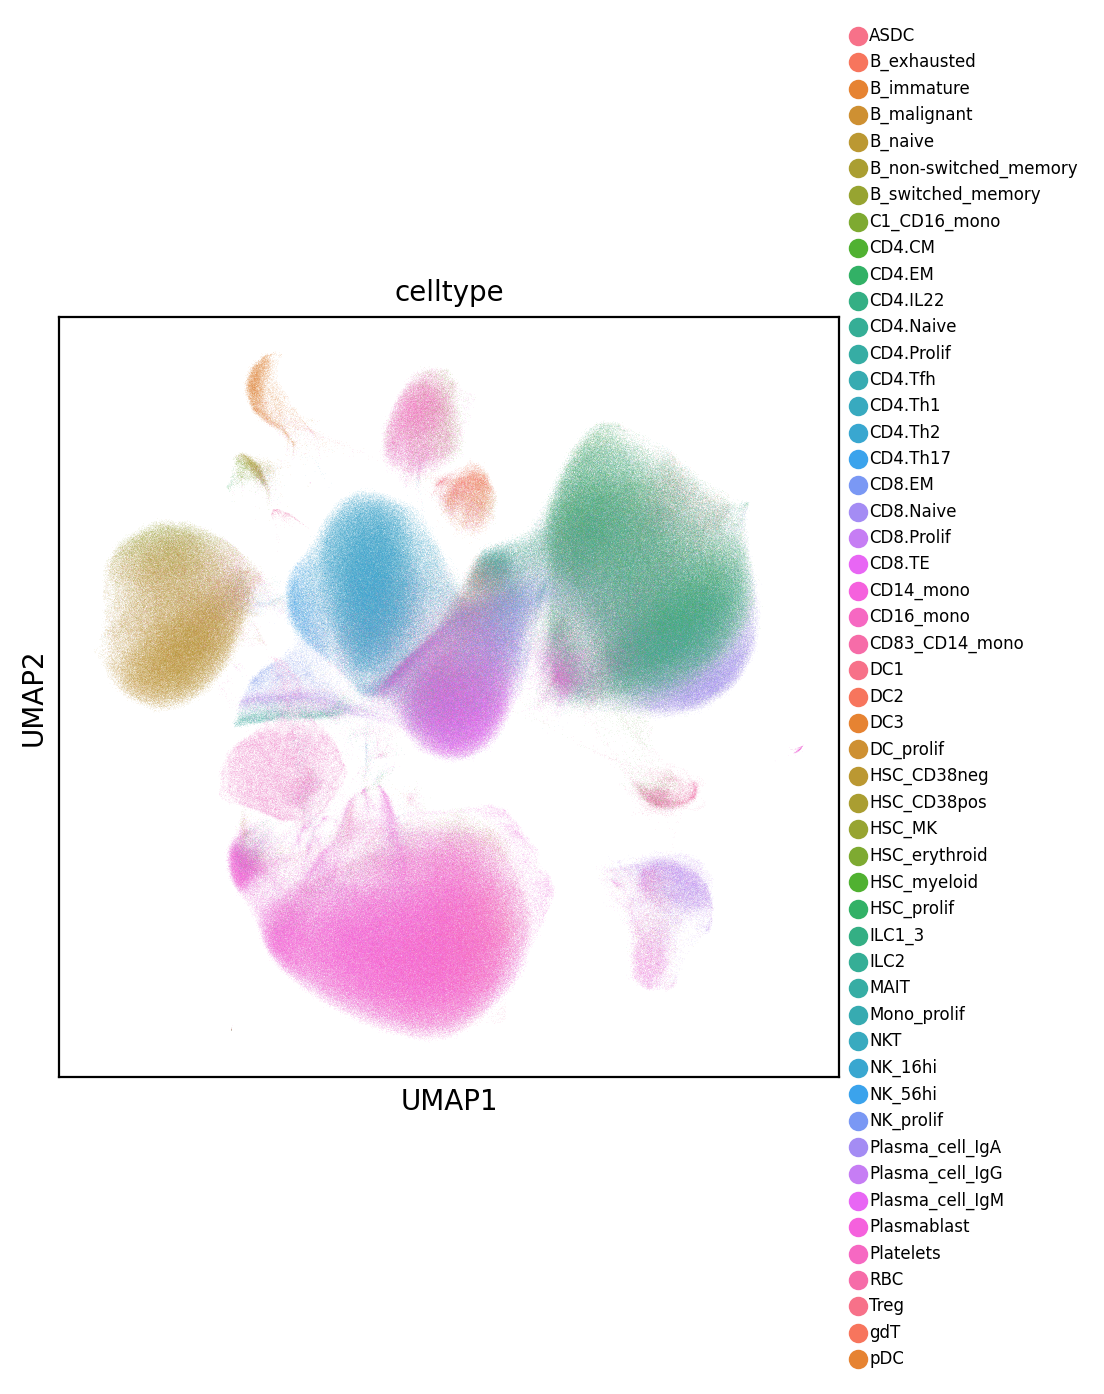

In [ ]:
leiden_umap = sc.pl.umap(adata, color=['celltype'],
    show=False, palette=sns.color_palette("husl", 24),
legend_fontsize=6, frameon=True, title='celltype')
lgd = one_col_lgd(leiden_umap)
fig = leiden_umap.get_figure()
fig.set_size_inches(5, 5)
fig.savefig(str(sc.settings.figdir) + '/umap_celltype.pdf', 
            format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
leiden_umap = sc.pl.umap(adata1, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of H',save="_attn_H.pdf")

In [ ]:
leiden_umap = sc.pl.umap(adata2, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of M',save="_attn_M.pdf")

In [ ]:
leiden_umap = sc.pl.umap(adata3, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of S',save="_attn_S.pdf")

# 2. Celltype-level

In [1]:
setwd('/data/wuqinhua/scPhase/COVID')
# rm(list = ls())
# gc()

library(tidyr)
library(ggplot2)
library(forestploter)
library(gridExtra)
library(tidyverse)
library(dplyr)
library(broom)
library(ggpubr)
library(randomForest)
library(mice)
library(reshape2)
library(Metrics)
library(ComplexHeatmap)
library(RColorBrewer)
library(fastcluster)
library(ggbeeswarm)
library(circlize)
library(ggrepel)
library(ggpubr)
library(scales) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:bas

### 2.1 Scatter trend plot

In [2]:
attnData = read.csv('./COVID_metadata.csv')
head(attnData)
colnames(attnData)

nameAll = unique(attnData$celltype)
nameAll = sort(nameAll)
nameAll

nameList = nameAll

sampleFold = data.frame(id = character(), celltype = character(), fold = numeric())
idList = unique(attnData$sample_id)
for (id in idList) {
  attnTmp = attnData %>% filter(sample_id == id)
  avgScore = 1 / dim(attnTmp)[1]
  foldRes = attnTmp %>% group_by(celltype) %>% summarise(res = median(log2(attention_weight_mean/avgScore)))
  dataTmp = data.frame(id = rep(id,dim(foldRes)[1]),
                       celltype = foldRes$celltype,
                       fold = foldRes$res)
  dataTmp_s = dataTmp %>% filter(celltype %in% nameList)
  dataTmp_s$fold = scale(dataTmp_s$fold)
  sampleFold = rbind(sampleFold,dataTmp_s)
}

sampleFold.Table = dcast(sampleFold,id ~ celltype)
rownames(sampleFold.Table) = sampleFold.Table$id
sampleFold.Table$id = NULL

sampleInfo = read.csv('./COVID19_sample_condition_560.csv')
rownames(sampleInfo) = sampleInfo$sample_id
sampleInfo = sampleInfo[rownames(sampleFold.Table),]
head(sampleFold.Table)

,X,batch,sample_id,phenotype,n_genes,n_genes_by_counts,total_counts,total_counts_MT,pct_counts_MT,leiden,celltype,over_clustering,majority_voting,attention_weight_mean,attention_weight_std
,<chr>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,AAACCCACATCTCAAG-1-Arunachalam2020-0,0,cov01,S,1032,1032,1839,140,7.612833,4,NK_16hi,430,B_switched_memory,7.112643e-05,7.167078e-05
2,AAACGCTGTAGCTTGT-1-Arunachalam2020-0,0,cov01,S,1850,1850,5966,226,3.788133,5,B_switched_memory,307,B_switched_memory,1.085322e-04,1.923282e-04
3,AAACGCTGTTTGACAC-1-Arunachalam2020-0,0,cov01,S,5905,5905,63097,3995,6.331521,9,B_naive,597,Plasma_cell_IgG,1.648905e-04,1.312977e-04
4,AAAGAACCATCAGCAT-1-Arunachalam2020-0,0,cov01,S,726,726,1738,79,4.545455,5,B_immature,136,B_naive,5.071729e-05,5.968442e-05
5,AAAGGATAGGCTATCT-1-Arunachalam2020-0,0,cov01,S,3960,3960,20807,1123,5.397222,12,DC2,704,DC1,6.171682e-05,8.585795e-05
6,AAAGGATAGGCTCAAG-1-Arunachalam2020-0,0,cov01,S,4711,4711,24860,1188,4.778761,16,HSC_CD38pos,598,HSC_CD38pos,4.394317e-05,4.343125e-05


[1] "X"                     "batch"                 "sample_id"            
 [4] "phenotype"             "n_genes"               "n_genes_by_counts"    
 [7] "total_counts"          "total_counts_MT"       "pct_counts_MT"        
[10] "leiden"                "celltype"              "over_clustering"      
[13] "majority_voting"       "attention_weight_mean" "attention_weight_std"

[1] "ASDC"                  "B_exhausted"           "B_immature"           
 [4] "B_malignant"           "B_naive"               "B_non-switched_memory"
 [7] "B_switched_memory"     "C1_CD16_mono"          "CD14_mono"            
[10] "CD16_mono"             "CD4.CM"                "CD4.EM"               
[13] "CD4.IL22"              "CD4.Naive"             "CD4.Prolif"           
[16] "CD4.Tfh"               "CD4.Th1"               "CD4.Th17"             
[19] "CD4.Th2"               "CD8.EM"                "CD8.Naive"            
[22] "CD8.Prolif"            "CD8.TE"                "CD83_CD14_mono"       
[25] "DC_prolif"             "DC1"                   "DC2"                  
[28] "DC3"                   "gdT"                   "HSC_CD38neg"          
[31] "HSC_CD38pos"           "HSC_erythroid"         "HSC_MK"               
[34] "HSC_myeloid"           "HSC_prolif"            "ILC1_3"               
[37] "ILC2"                  "MAIT"                  "Mono_prolif"          
[40] "NK_16hi"               "NK_56hi"               "NK_prolif"            
[43] "NKT"                   "pDC"                   "Plasma_cell_IgA"      
[46] "Plasma_cell_IgG"       "Plasma_cell_IgM"       "Plasmablast"          
[49] "Platelets"             "RBC"                   "Treg"

Using fold as value column: use value.var to override.



,ASDC,B_exhausted,B_immature,B_malignant,B_naive,B_non-switched_memory,B_switched_memory,C1_CD16_mono,CD14_mono,CD16_mono,⋯,NK_prolif,NKT,pDC,Plasma_cell_IgA,Plasma_cell_IgG,Plasma_cell_IgM,Plasmablast,Platelets,RBC,Treg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
563,NA,0.85559379,2.33333272,-1.49455365,1.3966075,0.3218587,0.86513775,0.1390107,-0.9106806,1.0854189,⋯,1.5649574,-0.3629644,1.0075266,0.9942611,-0.05811735,1.44969857,0.4576154,-0.4275404,-1.45944824,-0.35524287
564_B,NA,-0.06208232,0.07860594,NA,-0.3238479,-0.1607056,-0.18791486,0.9238836,-0.4134575,2.1891546,⋯,-0.1620700,-0.4483595,-1.0418814,0.2236028,-0.33392980,NA,-0.4823005,-0.8818482,-0.67605081,NA
565,NA,0.99133695,1.37816099,-0.08569683,1.0084859,1.3967669,0.09150147,1.0870676,-0.6703651,2.2957388,⋯,0.7498408,-0.2987790,0.3749175,0.6723521,-0.36811777,1.74310000,0.9421177,-1.4804184,-1.08770494,0.07819673
566,NA,1.48072113,1.29766771,-0.20446882,0.8487774,1.0584925,0.26226763,-0.9775221,-0.8790732,-0.4461315,⋯,1.1302397,-0.1242419,0.2935195,0.7178974,0.05029965,1.29345797,0.4835768,-0.8260363,-1.06034102,-0.97759689
568_PBMC,2.462332,-0.68765735,-0.62799236,0.65905778,-0.7743757,-0.6574198,-0.38534916,0.1317115,0.3577375,3.5772504,⋯,-0.2314123,-0.7387009,1.5267575,0.2030791,-0.27615481,-0.43595500,-0.1625539,-0.4388056,0.08682856,-0.04287672
569_PBMC,NA,-0.24948839,-0.13733173,-0.17229336,-0.2233706,-0.2357281,-0.33006720,0.1857429,0.6823539,-0.1978199,⋯,-0.1531063,-0.4700645,-0.3499601,0.3930855,0.35063741,0.01505188,0.7387612,-0.3403700,0.17694997,-0.50853535


,cell_type,kruskal_wallis_p_value,neg_log10_pval
,<chr>,<dbl>,<dbl>
1,ASDC,4.948690e-08,7.305510
2,B_exhausted,4.570488e-34,33.340037
3,B_immature,3.943242e-47,46.404147
4,B_malignant,8.606008e-02,1.065198
5,B_naive,2.242025e-56,55.649360
6,B_non-switched_memory,3.348085e-42,41.475204


,cell_type,overall_sd
,<chr>,<dbl>
1,ASDC,0.5889841
2,B_exhausted,0.6402404
3,B_immature,0.8042454
4,B_malignant,0.9038485
5,B_naive,0.6091523
6,B_non-switched_memory,0.6219480


,cell_type,kruskal_wallis_p_value,neg_log10_pval,overall_sd,scaled_pval,scaled_sd,keyness_score,label_text
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ASDC,4.948690e-08,7.305510,0.5889841,0.11838645,0.2057250,0.024355047,
2,B_exhausted,4.570488e-34,33.340037,0.6402404,0.54246802,0.2410253,0.130748501,
3,B_immature,3.943242e-47,46.404147,0.8042454,0.75527188,0.3539757,0.267347862,B_immature
4,B_malignant,8.606008e-02,1.065198,0.9038485,0.01673679,0.4225724,0.007072504,
5,B_naive,2.242025e-56,55.649360,0.6091523,0.90586898,0.2196148,0.198942243,B_naive
6,B_non-switched_memory,3.348085e-42,41.475204,0.6219480,0.67498335,0.2284272,0.154184582,


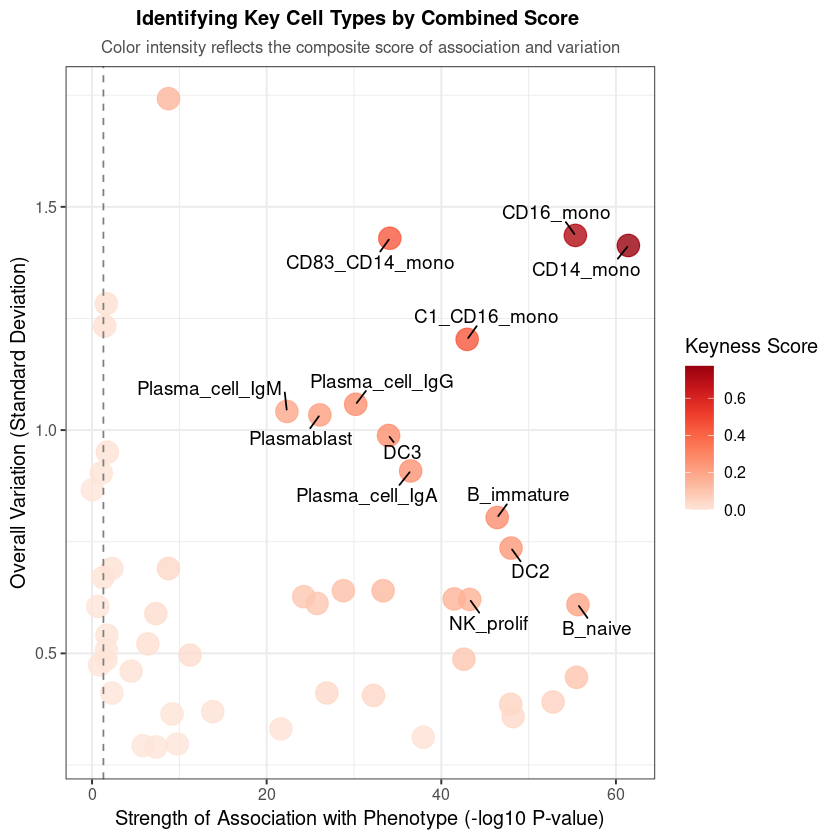

In [3]:
# ===================================================================
# 1. Score 1: Association with categorical phenotypes (Kruskal-Wallis test)
# ===================================================================

sampleInfo$Phenotype <- as.factor(sampleInfo$group)
sampleInfo <- sampleInfo[rownames(sampleFold.Table), ]

phenotype_association_scores_class <- data.frame(
  cell_type = character(),
  kruskal_wallis_p_value = numeric()
)

for (cell in colnames(sampleFold.Table)) {
  test_data <- data.frame(
    score = sampleFold.Table[[cell]],
    group = sampleInfo$Phenotype
  )

  test_result <- kruskal.test(score ~ group, data = test_data)

  phenotype_association_scores_class <- rbind(
    phenotype_association_scores_class,
    data.frame(
      cell_type = cell,
      kruskal_wallis_p_value = test_result$p.value
    )
  )
}

phenotype_association_scores_class <- phenotype_association_scores_class %>%
  mutate(neg_log10_pval = -log10(kruskal_wallis_p_value))

head(phenotype_association_scores_class)


# ===================================================================
# 2. Score 2: Group Volatility (Standard Deviation)
# ===================================================================

overall_variation_scores <- data.frame(
  cell_type = character(),
  overall_sd = numeric()
)

for (cell in colnames(sampleFold.Table)) {
  sd_val <- sd(sampleFold.Table[[cell]], na.rm = TRUE)
  overall_variation_scores <- rbind(
    overall_variation_scores,
    data.frame(
      cell_type = cell,
      overall_sd = sd_val
    )
  )
}
head(overall_variation_scores)


plot_data_combined_score <- merge(
  phenotype_association_scores_class, 
  overall_variation_scores, 
  by = "cell_type"
) %>%
  mutate(
    scaled_pval = rescale(neg_log10_pval, to = c(0, 1)),
    scaled_sd = rescale(overall_sd, to = c(0, 1)),
    keyness_score = scaled_pval * scaled_sd,
    label_text = ifelse(keyness_score > quantile(keyness_score, 0.75, na.rm = TRUE), cell_type, "")
  )

head(plot_data_combined_score)


combined_score_plot <- ggplot(plot_data_combined_score, 
                              aes(x = neg_log10_pval, 
                                  y = overall_sd, 
                                  color = keyness_score, 
                                  label = label_text)) +

  geom_point(size = 6, alpha = 0.8) +
  scale_color_distiller(palette = "Reds", direction = 1, name = "Keyness Score") +
  geom_text_repel(color = "black", size = 4, max.overlaps = Inf,
                  box.padding = 0.6, min.segment.length = 0) +

  geom_vline(xintercept = -log10(0.05), linetype = "dashed", color = "gray50") +
  theme_bw(base_size = 12) +
  labs(
    title = "Identifying Key Cell Types by Combined Score ",
    subtitle = "Color intensity reflects the composite score of association and variation",
    x = "Strength of Association with Phenotype (-log10 P-value)",
    y = "Overall Variation (Standard Deviation)"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
    plot.subtitle = element_text(hjust = 0.5, size = 10, color = "gray30"),
    legend.position = "right"
  )


ggsave("./Analysis/Figure/Attn_plot/classification_combined_score_plot.pdf", 
       combined_score_plot, 
       width = 9, height = 6, dpi = 300)

print(combined_score_plot)

### 2.2 Violin Plot 

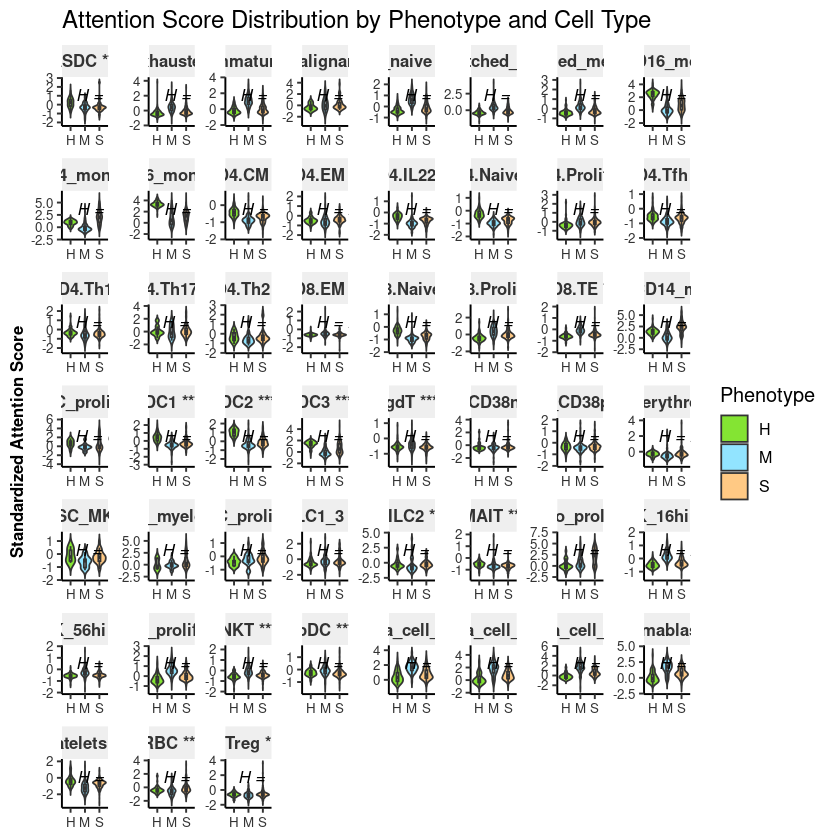

In [4]:
library(ggtext) 
cell_types_attn <- colnames(sampleFold.Table)
combined_data_atten <- data.frame()
for (cell in cell_types_attn) {
  dataTmp <- data.frame(
    atten = sampleFold.Table[[cell]],
    group = sampleInfo$group,
    cell_type = cell
  )
  dataTmp_s <- na.omit(dataTmp)
  combined_data_atten <- rbind(combined_data_atten, dataTmp_s)
}

custom_colors <- c("H" = '#66DD00', "M" = '#77DDFF', "S" = '#FFBB66')

plot_df_attn <- combined_data_atten %>%
  dplyr::rename(Attn = atten, group = group) %>%
  dplyr::mutate(group = factor(group, levels = names(custom_colors))) %>%
  na.omit()


annotation_data <- plot_df_attn %>%
  group_by(cell_type) %>%
  summarise(
    kruskal_test_res = list(kruskal.test(Attn ~ group)),
    p_value = kruskal_test_res[[1]]$p.value,
    h_statistic = kruskal_test_res[[1]]$statistic,
    .groups = 'drop'
  ) %>%
  mutate(
    significance = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01  ~ "**",
      p_value < 0.05  ~ "*",
      TRUE ~ "ns"
    ),
    title_with_sig = paste0(cell_type, " ", significance),
    
    stat_label = paste0(
        "H = ", round(h_statistic, 2),     
        ", ",                              
        scales::pvalue(p_value,             
                       accuracy = 0.001, 
                       add_p = TRUE)
    )
  )

plot_df_attn_final <- plot_df_attn %>%
  left_join(annotation_data %>% select(cell_type, title_with_sig), by = "cell_type") %>%

  filter(!is.na(title_with_sig))


p_facet_classification <- ggplot(plot_df_attn_final, aes(x = group, y = Attn, fill = group)) +
  geom_violin(trim = FALSE, alpha = 0.8) +
  geom_boxplot(width = 0.15, fill = "white", alpha = 0.7, outlier.shape = NA) +
  geom_text(
    data = annotation_data, 
    aes(label = stat_label), 
    x = -Inf, y = Inf,
    hjust = -0.1, vjust = 2,
    size = 3.5,
    fontface = "italic",
    inherit.aes = FALSE
  ) + 

  scale_fill_manual(values = custom_colors, name = "Phenotype") +

  facet_wrap(~title_with_sig, scales = "free") +

  labs(
    title = "Attention Score Distribution by Phenotype and Cell Type",
    y = "Standardized Attention Score"
  ) +

  theme_classic(base_size = 12) +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_rect(fill = "#EFEFEF", color = NA),
    strip.text = element_text(size = 10, face = "bold", color = "#333333"),
    axis.text = element_text(size = 8, color = "#333333"),
    axis.title = element_text(size = 10, face = "bold"),
    legend.position = "right",
    axis.title.x = element_blank()
  )

ggsave("./Analysis/Figure/Attn_plot/attn_classification_violin_plot.png",
       p_facet_classification, width = 20, height = 16, dpi = 300)

print(p_facet_classification)
